## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [29]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import glob
%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        #img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        #cv2.imshow('img',img)
        #cv2.waitKey(500)

#cv2.destroyAllWindows()

##  1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
## 2. Apply a distortion correction to raw images.

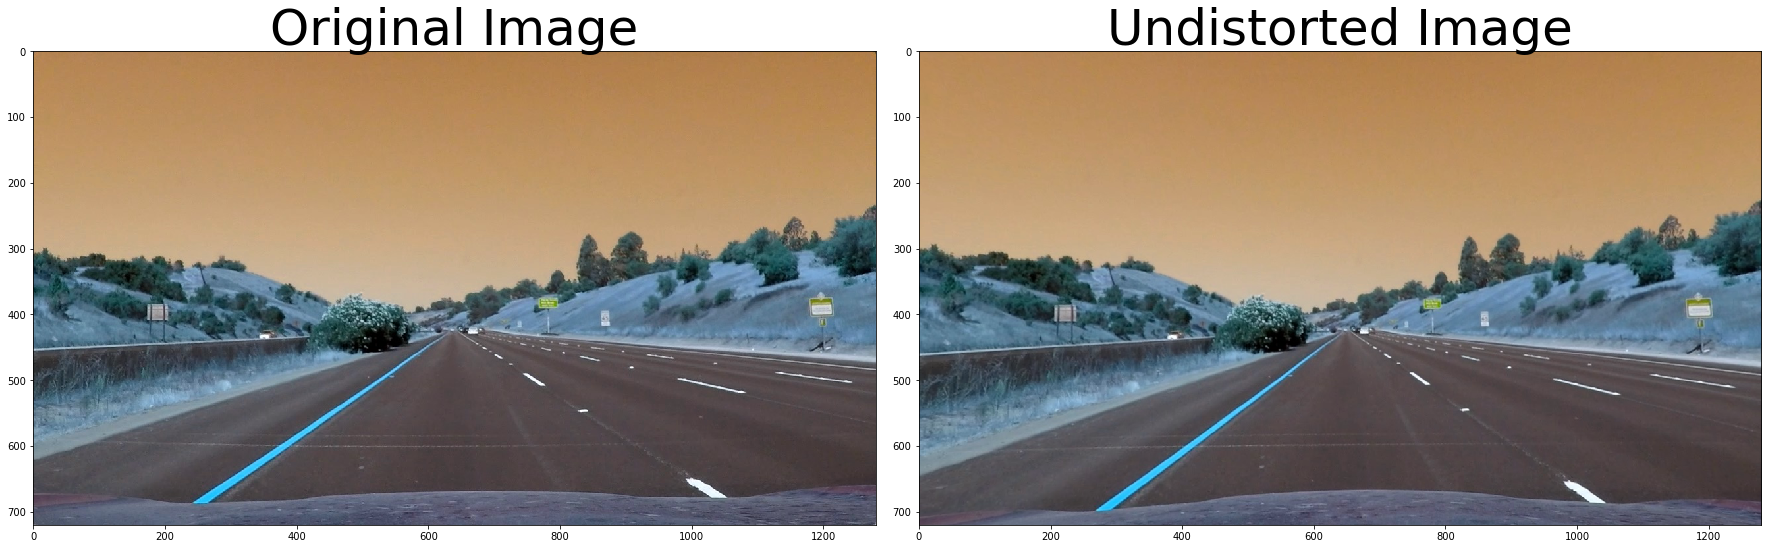

In [30]:
%matplotlib inline
# Make a list of calibration images
fname = 'test_images/straight_lines1.jpg'
img = cv2.imread(fname)

def cal_undistort(img, objpoints, imgpoints):
    # Use cv2.calibrateCamera() and cv2.undistort()
    #gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    #ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
    #img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
    h, w = img.shape[:2]
    rms, camera_matrix, dist_coefs, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, (w, h), None, None)
    newcameramtx, roi = cv2.getOptimalNewCameraMatrix(camera_matrix, dist_coefs, (w, h), 0, (w, h))
    dst = cv2.undistort(img, camera_matrix, dist_coefs, None, newcameramtx)
    return dst

undistorted = cal_undistort(img, objpoints, imgpoints)

#save undistorted image to select warp points
cv2.imwrite('test_images/straight_lines1_undistorted.png',undistorted, [int( cv2.IMWRITE_JPEG_QUALITY), 95])

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## 3. Use color transforms, gradients, etc., to create a thresholded binary image.

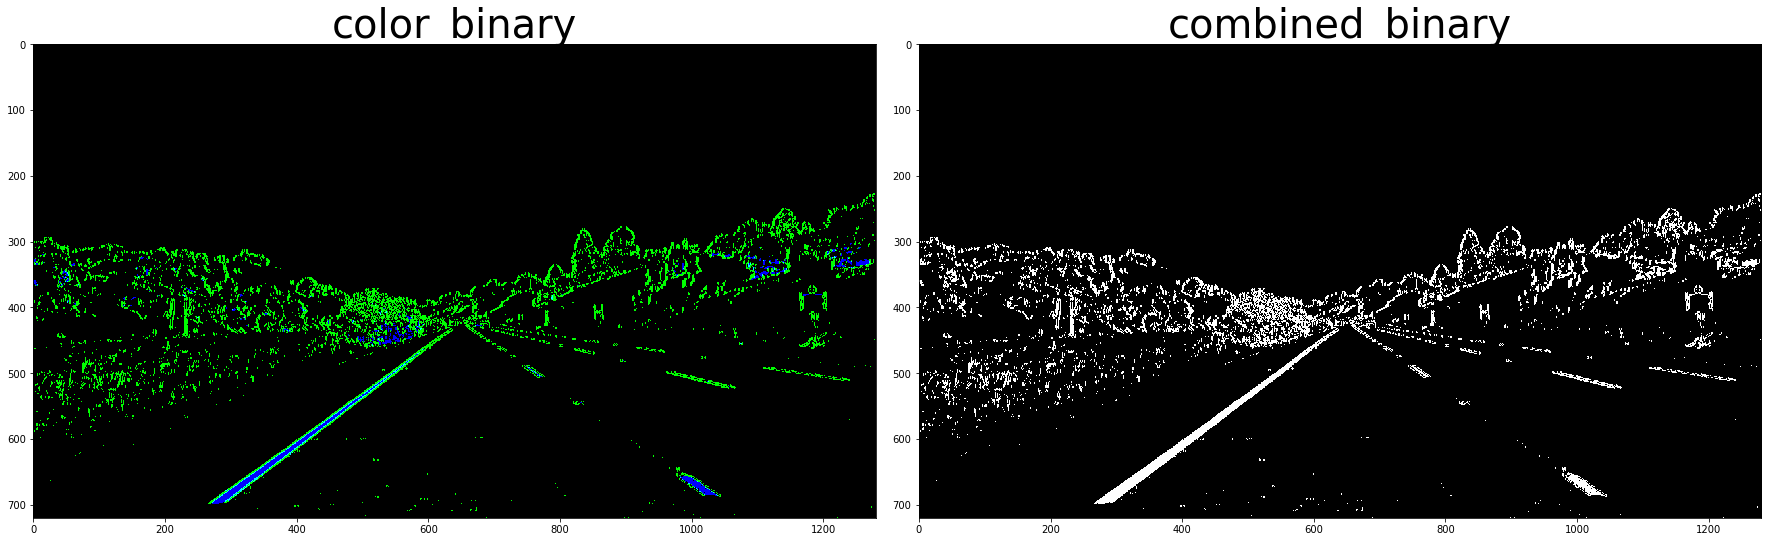

In [31]:
%matplotlib inline

import numpy as np
import cv2
import matplotlib.pyplot as plt

#fname = 'test_images/test6.jpg'
#image = cv2.imread(fname)

# Use distortion image
image = undistorted

# Edit this function to create your own pipeline.
def pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    #hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    s_channel = hls[:,:,2]
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255

    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

    return color_binary,combined_binary
    
color_binary,combined_binary = pipeline(image)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(color_binary)
ax1.set_title('color_binary', fontsize=40)

ax2.imshow(combined_binary,cmap='gray')
ax2.set_title('combined_binary', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()


## Apply a perspective transform to rectify binary image ("birds-eye view").

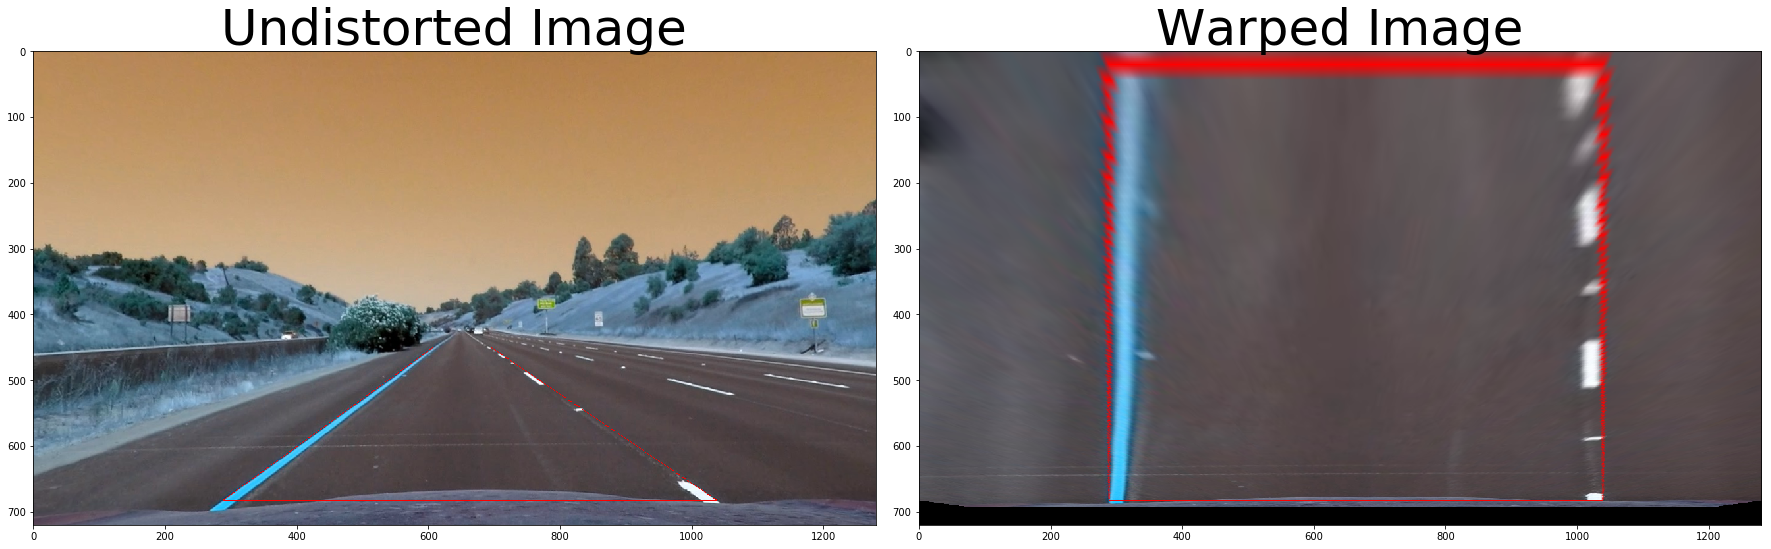

In [32]:
import matplotlib.image as mpimg
%matplotlib inline

#right top     [763,496]
#right bottom [1038,682]
# left bottom [288,682]
# left top    [545,496]



# MODIFY THIS FUNCTION TO GENERATE OUTPUT 
# THAT LOOKS LIKE THE IMAGE ABOVE
def unwarp(img):

    # b) define 4 source points src = np.float32([[,],[,],[,],[,]])
    # c) define 4 destination points dst = np.float32([[,],[,],[,],[,]])
    # d) use cv2.getPerspectiveTransform() to get M, the transform matrix
    # e) use cv2.warpPerspective() to warp your image to a top-down view

    img_size = (img.shape[1],img.shape[0])
    
    # Four source coordinates
    src = np.float32([[694,449],[1038,682],[288,682],[608,449]])
    
    # Four dstination coordinates
    dst = np.float32([[1038,20],[1038,682],[288,682],[288,20]])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped, M

# Choose 
pts = np.array([[694,449],[1038,682],[288,682],[608,449]], np.int32)  
pts = pts.reshape((-1,1,2))  
imd = cv2.polylines(image,[pts],True,(255,0,0),1)  
cv2.imwrite('test_images/straight_lines1_undistorted_withpoints.png',imd, [int( cv2.IMWRITE_JPEG_QUALITY), 95])

top_down, perspective_M = unwarp(image)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Undistorted Image', fontsize=50)
ax2.imshow(top_down)
ax2.set_title('Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


In [33]:
### test warp

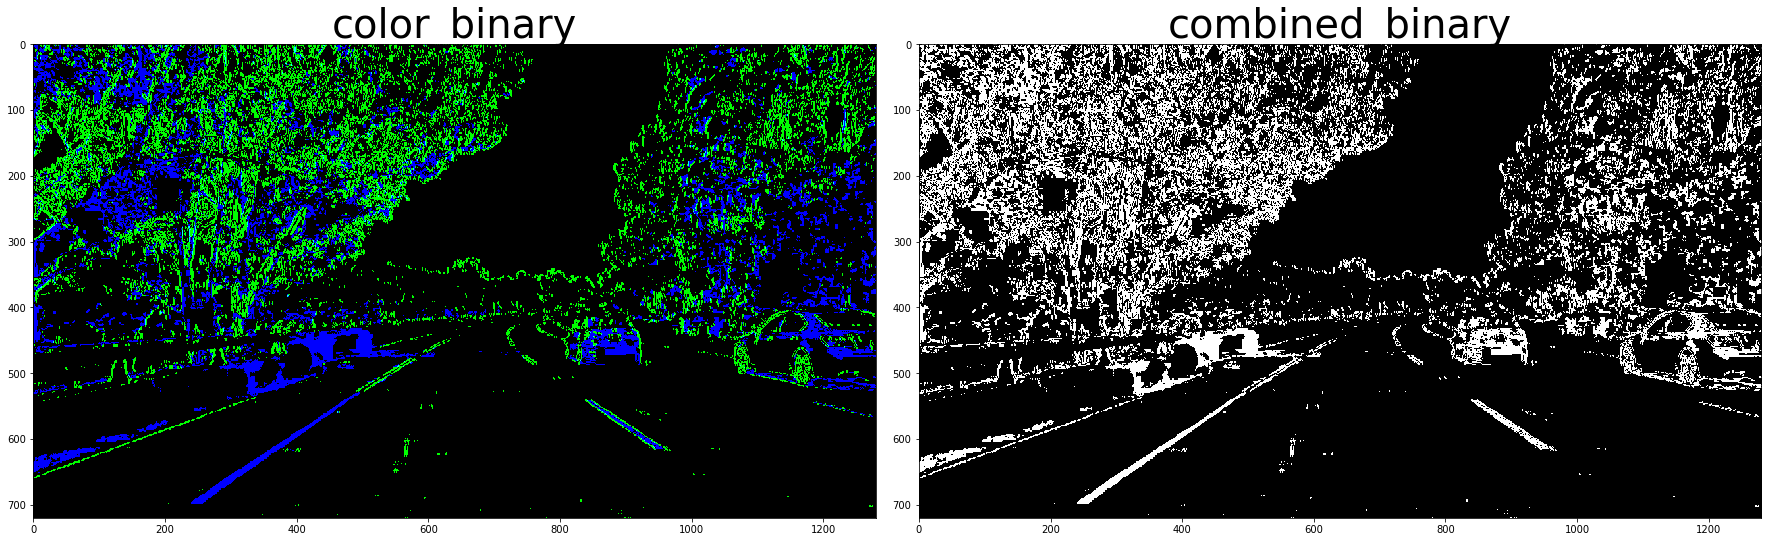

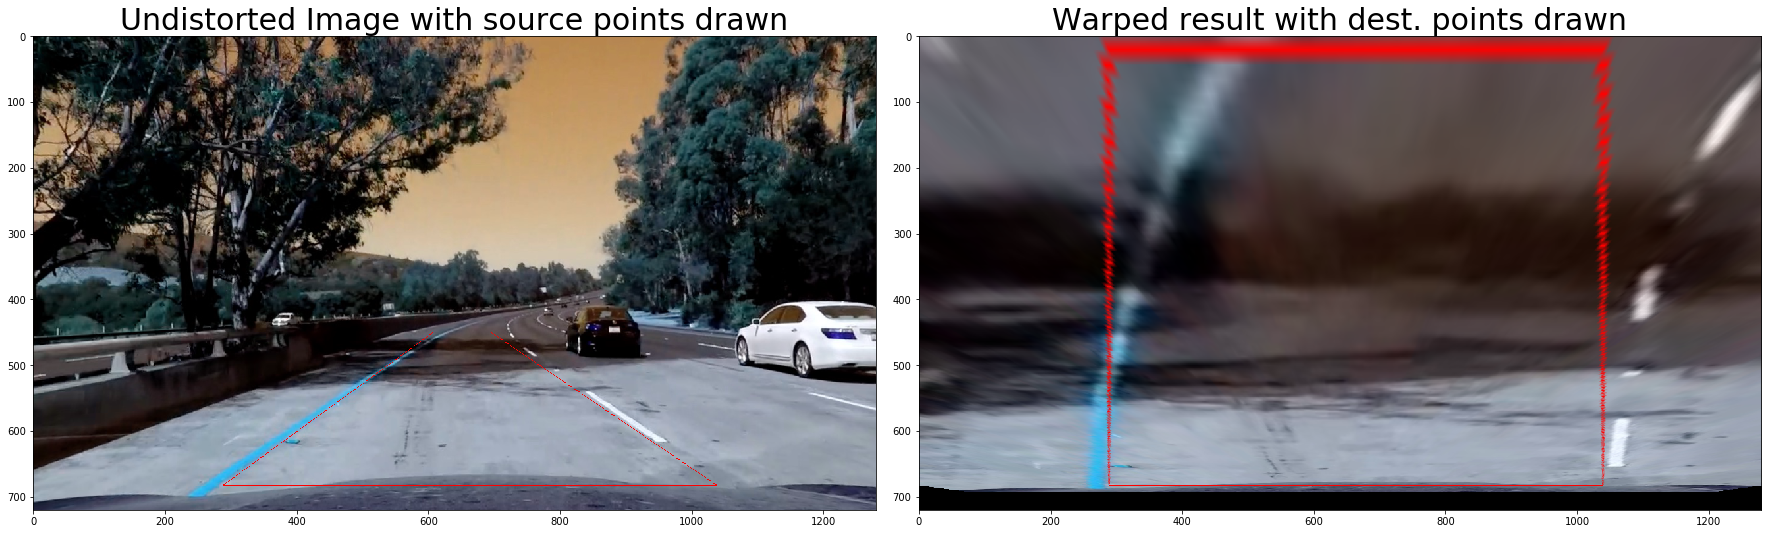

In [54]:
from PIL import Image


fname = 'test_images/test5.jpg'
img = cv2.imread(fname)
undistorted = cal_undistort(img, objpoints, imgpoints)
color_binary,combined_binary = pipeline(undistorted)
combined_binary_img = Image.fromarray(combined_binary)


# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(color_binary)
ax1.set_title('color_binary', fontsize=40)

ax2.imshow(combined_binary_img,cmap='gray')
ax2.set_title('combined_binary', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()


pts = np.array([[694,449],[1038,682],[288,682],[608,449]], np.int32)  
pts = pts.reshape((-1,1,2))  
imd = cv2.polylines(undistorted,[pts],True,(255,0,0),1)  
cv2.imwrite('test_images/straight_lines1_undistorted_withpoints.png',imd, [int( cv2.IMWRITE_JPEG_QUALITY), 95])

img_size = (undistorted.shape[1],undistorted.shape[0])
warped = cv2.warpPerspective(undistorted, perspective_M, img_size, flags=cv2.INTER_LINEAR)






f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(undistorted)
ax1.set_title('Undistorted Image with source points drawn', fontsize=30)
ax2.imshow(warped)
ax2.set_title('Warped result with dest. points drawn', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)



## Detect lane pixels and fit to find the lane boundary.